#Импорт всех необходимых библиотек

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-jyhxprz4
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-jyhxprz4


In [ ]:
! pip freeze | grep 'album'

albumentations @ git+https://github.com/albu/albumentations@89a675cbfb2b76f6be90e7049cd5211cb08169a5


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.5.2.52
Uninstalling opencv-python-headless-4.5.2.52:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.2.52.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-8daa01ff.so.58.109.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-06a336f2.so.58.61.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-01d48d95.so.56.60.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-098682aa.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libpng15-c2ffaf3d.so.15.13.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libssl-f3db6a3b.so.1.1
    /usr/local/lib/python3.7/dist-package

In [ ]:
!pip install opencv-python-headless==4.5.2.52

  Using cached opencv_python_headless-4.5.2.52-cp37-cp37m-manylinux2014_x86_64.whl (38.2 MB)


In [ ]:
import cv2
import random
import torch
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import os
import pandas as pd
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import re
import xml.etree.ElementTree as ET
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

# Скачаем датасет

[The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

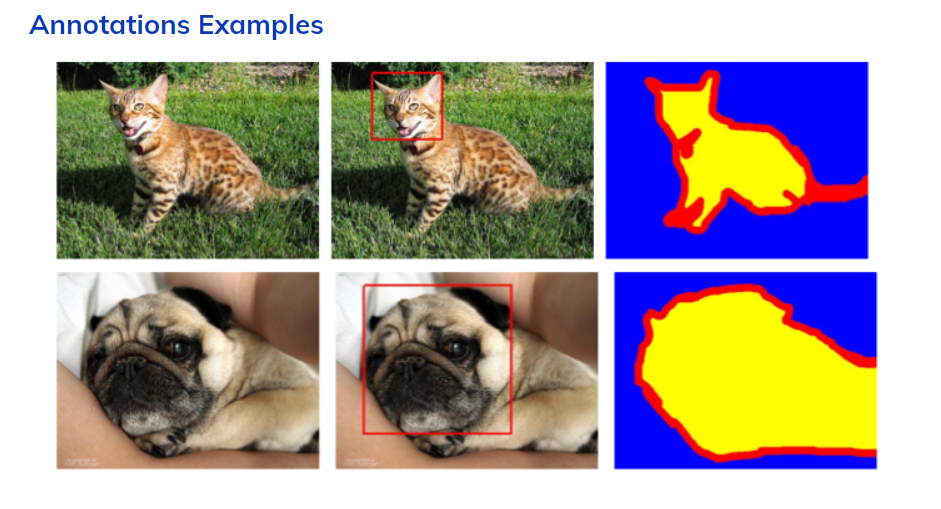

In [ ]:
!mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0   105M      0  0:00:07  0:00:07 --:--:--  109M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  14.6M      0  0:00:01  0:00:01 --:--:-- 14.6M


In [ ]:
!tar -xf images.tar.gz -C dataset/
!tar -xf annotations.tar.gz -C dataset/

# Разделим датасет на подвыборки

Некоторые файлы в наборе данных повреждены, поэтому мы будем использовать только те файлы изображений, которые OpenCV может правильно загрузить.

In [ ]:
dataset_directory = 'dataset'
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

Разметка датасета хранится в файлах XML, потому что она имеет формат PASCAL VOC. В данном датасете размеченно 3686 фотографиий. Соберем датафрейм, в котором для размеченных изображений будут храниться bbox

In [ ]:
annot_dir = Path("dataset/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]
ann_pths = []
print("[INFO] Creating the paths to the annotations ...")
for a in tqdm(annots):
    for i in correct_images_filenames:
        i_pth = i.split(os.path.sep)[-1].split(".")[0]
        a_pth = a.split(os.path.sep)[-1].split(".")[0]
        if i_pth == a_pth : ann_pths.append(a)
print("Annotation files found : ", len(ann_pths))

[INFO] Creating the paths to the annotations ...


100%|██████████| 3686/3686 [00:33<00:00, 108.59it/s]

Annotation files found :  3686


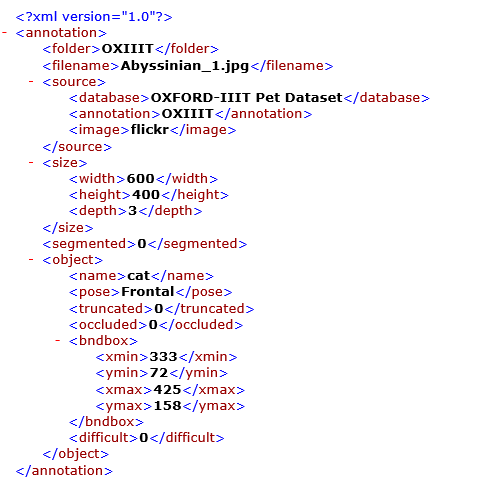

In [ ]:
def xml_to_csv(pths:list) -> pd.DataFrame:
    """Extracts the filenames and the bboxes from the xml_list"""
    print("[INFO] Gathering the filenames and bboxes")
    xml_list = []
    for xml_file in tqdm(pths):
      tree=ET.parse(xml_file)
      root =tree.getroot()
      for m in root.findall("object"):
          try:
            value=(
                str(root.find("filename").text),
                float(m[4][0].text),
                float(m[4][1].text),
                float(m[4][2].text),
                float(m[4][3].text),
           )
            xml_list.append(value)
          except exepsion as e: print(e)
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df

In [ ]:
df = xml_to_csv(ann_pths)

[INFO] Gathering the filenames and bboxes


100%|██████████| 3686/3686 [00:00<00:00, 22899.46it/s]


In [ ]:
df.head()

filename   xmin   ymin   xmax   ymax
0               Russian_Blue_168.jpg   51.0  120.0  151.0  230.0
1  american_pit_bull_terrier_144.jpg  156.0   20.0  228.0   81.0
2                      Persian_1.jpg   42.0   22.0  115.0   84.0
3              japanese_chin_167.jpg  210.0   52.0  367.0  177.0
4         miniature_pinscher_142.jpg   50.0   59.0  152.0  175.0

Оставляем в наборе данных только те файлы, для которых есть разметка

In [ ]:
dataset_filenames = df['filename'].unique()

# Визуализируем датасет

In [ ]:
def display_image_grid(images_filenames, images_directory):
    cols = 2
    rows = 7
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        '''
        откройте картинку, найдите bbox для картинки в датасете, отрисуйте на картинке bbox с помощью cv2.rectangle
        '''
        image_path = os.path.join(images_directory, image_filename)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_info = df[df['filename']==image_filename].values
        x1, y1, x2, y2 = img_info[0][1:]
        img_rect = img.copy()
        img_rect = cv2.rectangle(img_rect, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 2)
        ax[i,0].imshow(img)
        ax[i,1].imshow(img_rect)
        if i == 6:
          return 
    plt.tight_layout()
    plt.show()

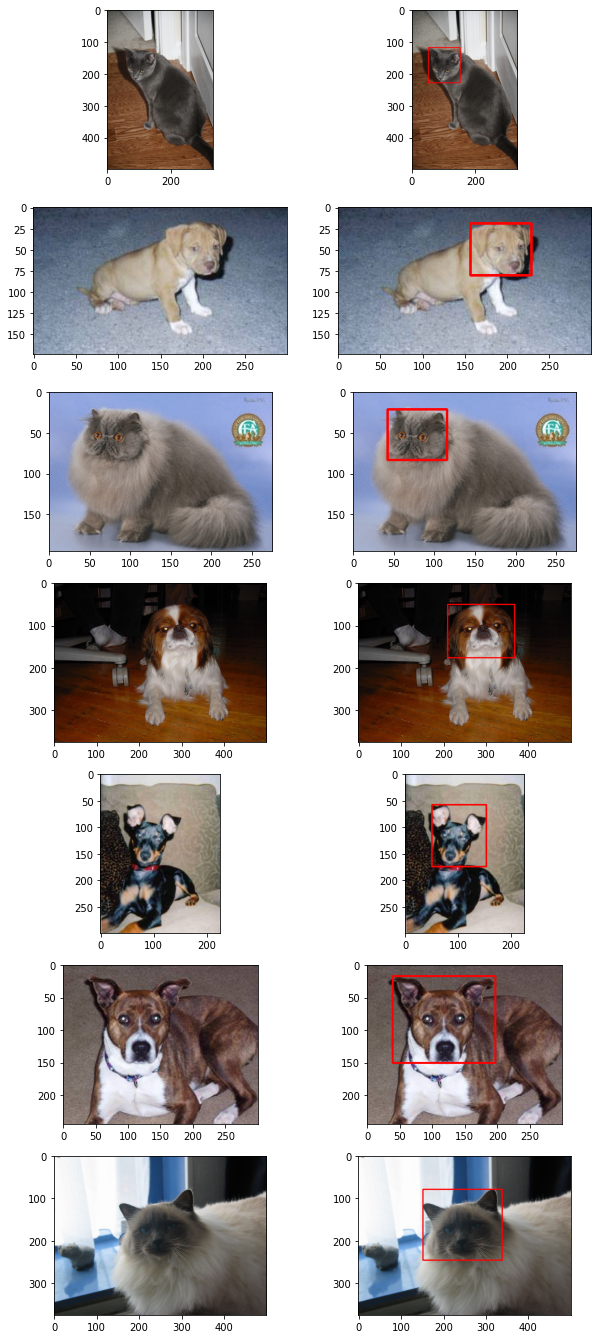

In [ ]:
display_image_grid(dataset_filenames, images_directory)

# Определим класс датасета

Из-за того, что модель предобучена на датасете СOCO __getitem__ должна возвращать:

*   image: PIL изображение размера (H, W)
*   target: словарь, который содержит следующие поля:

      *   boxes (FloatTensor[N, 4]): массив из N координат bbox в [x0, y0, x1, y1] формате
      *   labels (Int64Tensor[N]): метка для каждого bbox. 0 всегда обозначает класс бэкграунда
      *   image_id (Int64Tensor[1]): идентификатор изображения. Он должен быть уникальным для каждого изображения в датасете
      *   area (Tensor[N]): площадь bbox. Используется при валидации модели для подсчета СОСО метрик
      *   iscrowd (UInt8Tensor[N]): объекты с iscrowd = True игнорируются во время валидации
      *   (опционально)  masks (UInt8Tensor[N, H, W]): маска для каждого изображения
      *   (опционально )keypoints (FloatTensor[N, K, 3]): для каждого объекта могут существовать ключевые точки, уточняющие положение объекта 

In [ ]:
class OxfordPetDataset(Dataset):

    def __init__(self, images_filenames, image_dir, transforms=None):
        super().__init__()
        self.image_ids = images_filenames
        self.image_dir = image_dir
        self.transforms = transforms

    def getitem(self, index: int):

        image_id = self.image_ids[index]
        records = df[df['filename'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)  #reading an image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #changing color space BGR --> RGB
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:,0])  #Calculating area of boxes
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] =  torch.tensor(sample['bboxes']).float()
        return image, target, image_id


    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_train_transform():
    return A.Compose(
        [
            
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensor(),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transform():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensor(),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_test_transform():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensor(),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )
                      

Мы будем использовать 1000 изображений для обучения, 300 изображения для проверки и 100 изображений для тестирования.

In [ ]:
random.seed(42)
random.shuffle(dataset_filenames)

train_images_filenames = dataset_filenames[:1000]
val_images_filenames = dataset_filenames[1000:1300]
test_images_filenames = dataset_filenames[1300:1400]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

Создаем даталоадеры

In [ ]:
!pip install --upgrade albumentations

In [ ]:
train_dataset = OxfordPetDataset(train_images_filenames, 'dataset/images', get_train_transform())
valid_dataset = OxfordPetDataset(val_images_filenames, 'dataset/images', get_valid_transform())

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size= 8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Определяем модель

Будем использовать готовую архитектуру Faster-RCNN из torchvision.models

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Определяем количество классов. Их два, потому что нам нужен класс, который будет обозначать бэкграунд

In [ ]:
num_classes = 2  

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Напишем обучение

Определяем параметры для обучения сети

In [ ]:
device = torch.device('cuda')
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 2
model.to(device)

Averager - кастомный класс, который считает среднее значение метрик

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def train(train_loader, model, optimizer, epoch):
  loss_hist = Averager()
  itr = 1

  loss_hist.reset()
  
  for images, targets, image_ids in train_loader:
      
     '''ваш код здесь'''
     images = list(image.to(device) for image in images)
     targets = [{k: v.to(device) for k,v in target.items()} for target in targets]

     loss_dict = model(images,targets)
     losses = sum(loss for loss in loss_dict.values())
     loss_hist.send(losses)

     optimizer.zero_grad()
     losses.backward()
     optimizer.step()

     if itr%10==0:
       print(f'train iter: {itr} Loss: {loss_value}')
     itr+=1

  print(f" Train epoch #{epoch} loss: {loss_hist.value}")

In [ ]:
def validate(val_loader, model, epoch):
  loss_hist = Averager()
  itr = 1

  loss_hist.reset()
  with torch.no_grad():
    for images, targets, image_ids in val_loader:
        '''ваш код здесь'''

    print(f" Validate epoch #{epoch} loss: {loss_hist.value}")

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(train_data_loader, model, optimizer, epoch)
    validate(valid_data_loader, model, epoch)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train iteration #10 loss: 0.22894524037837982
Train iteration #20 loss: 0.1826075166463852
Train iteration #30 loss: 0.24094997346401215
Train iteration #40 loss: 0.17029359936714172
Train iteration #50 loss: 0.16183240711688995
Train iteration #60 loss: 0.1294592320919037
Train iteration #70 loss: 0.1379447728395462
Train iteration #80 loss: 0.1598242223262787
Train iteration #90 loss: 0.11860879510641098
Train iteration #100 loss: 0.11891936510801315
Train iteration #110 loss: 0.09888781607151031
Train iteration #120 loss: 0.10131929814815521
 Train epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
Train iteration #10 loss: 0.10201353579759598
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 Validate epoch #1 loss: 0
 

# Посмотрим на результаты обучения модели

In [ ]:
test_dataset = OxfordPetDataset(test_images_filenames, 'dataset/images', get_test_transform())

In [ ]:
test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
model.eval()

In [ ]:
def predict(model, test_data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, targets, image_ids  in  test_data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)
            outputs = [{k: v.to('cpu') for k, v in t.items()}  for t in outputs]
            outputs = zip(outputs, image_ids)
            for output in outputs:
              predictions.append(output)
    return predictions

In [ ]:
predictions = predict(model, test_data_loader)

Отрисуем результат теста модели

In [ ]:
cols = 2
rows = 10
figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
for i in range(rows):
    prediction = predictions[i]
    '''
    проитерируйтесь по результатам работы сети, вытащите оттуда bbox и отрисуйте их
    '''

plt.tight_layout()
plt.show()